## Import library

In [1]:
import pathlib
import tensorflow as tf
import zipfile
import os
import IPython.display as display
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

tf.random.set_seed(102)
np.random.seed(102)

In [2]:
print('TensorFLow version:', tf.__version__)
print('GPU available:', tf.test.is_gpu_available())

TensorFLow version: 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


## Download data from Kaggle

In [3]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !echo '{"username":"huynhdao0808","key":"5c54c0e85b1f418010be165ba094552e"}' > ~/.kaggle/kaggle.json
# !kaggle competitions download -c imaterialist-fashion-2020-fgvc7

In [4]:
MODEL_FOLDER = "/home/jupyter/iMaterialist/model"
DATA_ROOT_FOLDER = "/home/jupyter/iMaterialist/data"
DATA_RAW_FOLDER = "/home/jupyter/iMaterialist/data/raw"
DATA_TRAIN_FOLDER = "/home/jupyter/iMaterialist/data/raw/train"
DATA_TEST_FOLDER = "/home/jupyter/iMaterialist/data/raw/test"

## Get label from json

In [5]:
with open(os.path.join(DATA_RAW_FOLDER,'label_descriptions.json')) as f:
  label_description_json = json.load(f)

label_description = {}
for label in label_description_json['categories']:
    label_description[label['id']] = label['name']

In [6]:
label_description

{0: 'shirt, blouse',
 1: 'top, t-shirt, sweatshirt',
 2: 'sweater',
 3: 'cardigan',
 4: 'jacket',
 5: 'vest',
 6: 'pants',
 7: 'shorts',
 8: 'skirt',
 9: 'coat',
 10: 'dress',
 11: 'jumpsuit',
 12: 'cape',
 13: 'glasses',
 14: 'hat',
 15: 'headband, head covering, hair accessory',
 16: 'tie',
 17: 'glove',
 18: 'watch',
 19: 'belt',
 20: 'leg warmer',
 21: 'tights, stockings',
 22: 'sock',
 23: 'shoe',
 24: 'bag, wallet',
 25: 'scarf',
 26: 'umbrella',
 27: 'hood',
 28: 'collar',
 29: 'lapel',
 30: 'epaulette',
 31: 'sleeve',
 32: 'pocket',
 33: 'neckline',
 34: 'buckle',
 35: 'zipper',
 36: 'applique',
 37: 'bead',
 38: 'bow',
 39: 'flower',
 40: 'fringe',
 41: 'ribbon',
 42: 'rivet',
 43: 'ruffle',
 44: 'sequin',
 45: 'tassel'}

## 1. EDA

Use pandas to read csv file

In [7]:
data = pd.read_csv(os.path.join(DATA_RAW_FOLDER,'train.csv'))

How our data look like?

In [8]:
data.head(10)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219
5,00000663ed1ff0c4e0132b9b9ac53f6e,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32,219
6,00000663ed1ff0c4e0132b9b9ac53f6e,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31,"160,204"
7,00000663ed1ff0c4e0132b9b9ac53f6e,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29,174
8,00000663ed1ff0c4e0132b9b9ac53f6e,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,"17,115,136,145,149,225,295,311,317"
9,0000fe7c9191fba733c8a69cfaf962b7,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33,190


In [9]:
data[(data['Height']>5000)&(data['Width']>7000)]

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
298,003ad8a37d2190bd944a8968fb0906e2,18556042 9 18561335 28 18566629 46 18571922 65...,5304,7952,2,"115,136,142,147,295,316,317"
299,003ad8a37d2190bd944a8968fb0906e2,20231766 2 20237070 2 20242374 2 20247677 4 20...,5304,7952,33,185
300,003ad8a37d2190bd944a8968fb0906e2,18556042 9 18561337 26 18566632 43 18571927 60...,5304,7952,31,"160,214"
301,003ad8a37d2190bd944a8968fb0906e2,26214692 11 26219985 31 26225278 52 26230576 6...,5304,7952,31,"160,214"
794,009447b79fce7da1ee19a54401517cde,25048107 6 25053398 19 25058690 32 25063981 45...,5304,7952,1,"10,115,135,142,146,295,316,317"
...,...,...,...,...,...,...
330074,fd69afa1dfaa14ad3518c5f26dba69f3,20560277 1 20565581 4 20570884 8 20576188 11 2...,5304,7952,33,190
331081,fe1fe5f270f3b47e6fefbbfbef160a87,25821073 25 25826334 74 25831614 104 25836912 ...,5304,7952,14,NaN
331082,fe1fe5f270f3b47e6fefbbfbef160a87,23282619 7 23287920 22 23293221 36 23298522 51...,5304,7952,13,NaN
331083,fe1fe5f270f3b47e6fefbbfbef160a87,24119885 1 24125188 3 24130491 6 24135795 7 24...,5304,7952,33,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333401 entries, 0 to 333400
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        333401 non-null  object
 1   EncodedPixels  333401 non-null  object
 2   Height         333401 non-null  int64 
 3   Width          333401 non-null  int64 
 4   ClassId        333401 non-null  int64 
 5   AttributesIds  206410 non-null  object
dtypes: int64(3), object(3)
memory usage: 15.3+ MB


We just need ImageId and ClassID for our prediction

In [11]:
clean_data = data[['ImageId','ClassId']]

Let's have a look at how our label distribute

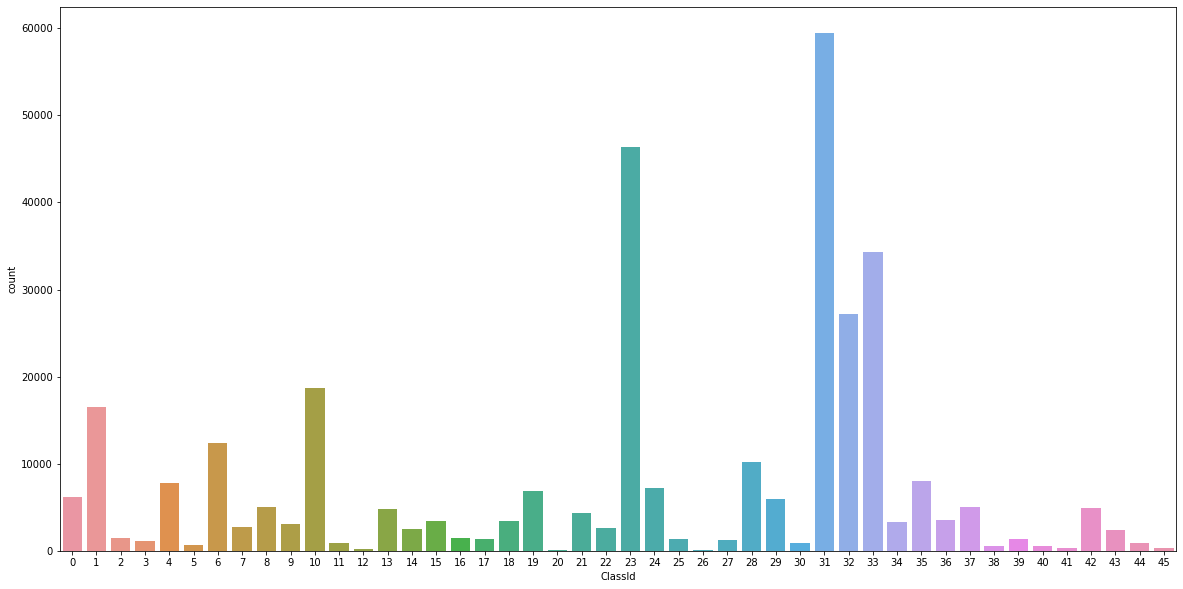

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(clean_data['ClassId'])
plt.show()

* Our label is clearly unbanlanced

Use one hot technique to get the label for our image

In [13]:
label_data = pd.concat((clean_data['ImageId'],pd.get_dummies(clean_data['ClassId'])),axis=1)

In [14]:
label_data = label_data.groupby('ImageId',as_index=False).sum()

In [15]:
label_data.head(10)

,ImageId,0,1,2,3,4,5,6,7,8,...,36,37,38,39,40,41,42,43,44,45
0,00000663ed1ff0c4e0132b9b9ac53f6e,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000fe7c9191fba733c8a69cfaf962b7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0002ec21ddb8477e98b2cbb87ea2e269,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0002f5a0ebc162ecfb73e2c91e3b8f62,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0004467156e47b0eb6de4aa6479cbd15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,00048c3a2fb9c29340473c4cfc06424a,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0006ea84499fd9a06fefbdf47a5eb4c0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,000775b6b5e27b011dc8bba2d7b85211,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,000aac3870ea7c59ca0333ffa5327323,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,000b3a87508b0fa185fbd53ecbe2e4c6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Some label value is more than 1 (because it appear more than 1 time in our image), but our target is just need to detect  it appear or not. So we will change it to 0 and 1 only
* Tranform ImageId to directory for easier manipulation with tf dataset

In [16]:
def to_directory(name):
    return os.path.join(DATA_TRAIN_FOLDER,str(name)+'.jpg')

In [17]:
label_data = pd.concat((label_data['ImageId'].apply(to_directory),label_data.drop(columns='ImageId')>0),axis=1)

In [18]:
label_data.shape

(45623, 47)

In [19]:
label_data.shape

(45623, 47)

### 1.1 Techniques for Unbalanced dataset

There are several technique to deal with Unbalanced dataset:
* **Random Undersampling and Oversampling** <br>
    A widely adopted and perhaps the most straightforward method for dealing with highly imbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).
    ![](https://miro.medium.com/max/725/0*FeIp1t4uEcW5LmSM.png)
* **Underssampling and Oversampling using imbalanced-learn**<br>
Undersampling using Tomek Links<br>
![](https://miro.medium.com/max/798/0*YWVxE7SbWKnTnbZi)<br>
Oversampling using SMOTE:<br>
![image.png](https://miro.medium.com/max/734/0*_XpwY9GznmejI4WN.png)<br>
* **Class weights in the models**<br>
In Loss function, the weight of monority classes will be higher then the majority classes
* **Change the Evaluation metric to F1 Score**<br>
When change the Evaluation metric to F1 Score can solve 2 problem:
    * Problem with unbalanced dataset (High accuracy but low precision)
    * No need to fine-tune the threshold for multilabel classification<br>
    ![](https://miro.medium.com/max/376/0*HZ1eOpKgyjnxMBQV.png)
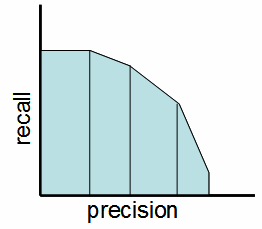

Because the limited time for the project, I will use `Random oversampling` and `F1 Score Evaluation Metric` technique

### 1.2 Random oversampling

I do not want data lost so in this project I use random oversampling. <br>But the number of copy need to be define, otherwise we must handle a really big amount of data

* Caculate average number of observation belongs to 1 class

In [20]:
divided_label_data = []
for i in range(46):
    divided_label_data.append(label_data[label_data[i]==1])

In [21]:
len_data =[]
for data in divided_label_data:
    len_data.append(len(data))

In [22]:
UNDER_OVER_NUMBER = np.mean(len_data).astype('int')
UNDER_OVER_NUMBER

5314

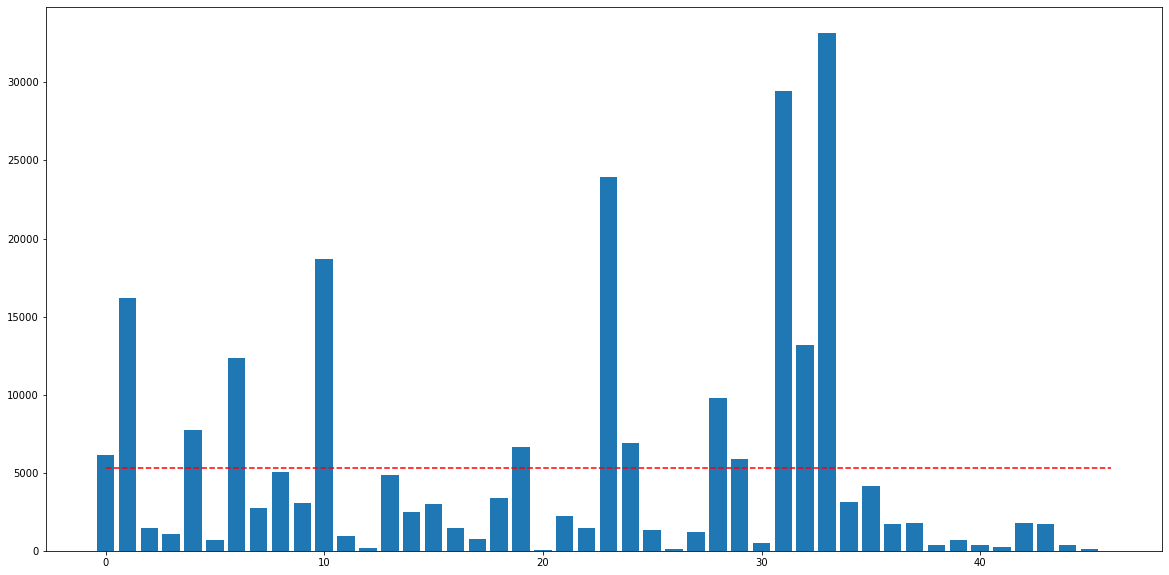

In [23]:
plt.figure(figsize=(20,10))
plt.bar(np.linspace(0,45,num=46,dtype='int'),len_data)
plt.plot([0., 46], [UNDER_OVER_NUMBER, UNDER_OVER_NUMBER], "k--", c='r')
plt.show()

* Look for the class that have number of obsevation smaller than the average

In [24]:
resample_class = np.argwhere(np.array(len_data)<5000)[:,0]
resample_class

array([ 2,  3,  5,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25,
       26, 27, 30, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

* Resample the minority class

In [25]:
resample_label_data = label_data.copy()
for _class in resample_class:
    no_additional_sample = UNDER_OVER_NUMBER-len(divided_label_data[_class])
    additional_sample = divided_label_data[_class].sample(no_additional_sample,replace=True, random_state=101)
    resample_label_data = pd.concat((resample_label_data,additional_sample))

In [26]:
resample_label_data.shape[0], label_data.shape[0]

(166299, 45623)

* Conclusition
Intuitively , we can see that the unbalance improve a little bit. But the trade off is that number of obervation inscrease from 45k to 166k

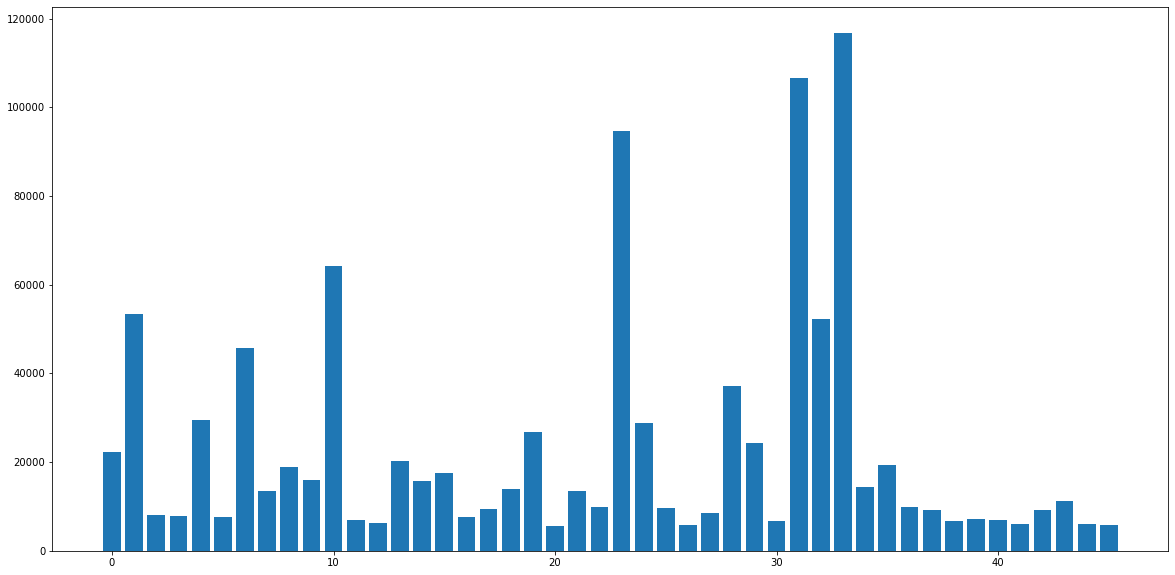

In [27]:
divided_label_data = []
for i in range(46):
    divided_label_data.append(resample_label_data[resample_label_data[i]==1])
    
len_data =[]
for data in divided_label_data:
    len_data.append(len(data))

plt.figure(figsize=(20,10))
plt.bar(np.linspace(0,45,num=46,dtype='int'),len_data)
plt.show()

## 2. Multilabel prediction with CNN

### 2.1 Preprocessing

Let's start with small sample first to inscrease our training speed 

Note: If we want to shuffle our data, we should do at this step. Because shuffule the list of string will be much faster than shuffle the dataset of image array with shape (224,224,3)

In [28]:
# sample_data = resample_label_data.sample(6000,random_state=101)
sample_data = resample_label_data.copy()
# label_data_20 = label_data[label_data[20]==1]
# sample_data = label_data_20.copy()

Split data into training set and validation test with 0.2 ratio

In [29]:
X = sample_data['ImageId'].to_numpy()
y = sample_data.drop(columns='ImageId').to_numpy().astype('int')

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state = 101)

In [31]:
X_train.shape, y_train.shape

((116409,), (116409, 46))

In [32]:
X_train[0], y_train[0]

('/home/jupyter/iMaterialist/data/raw/train/c629ff9abaf307a006ab7e50db9436bf.jpg',
 array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))

Tranform out dataset into tf.dataDataset instance.

In [33]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val))

Currently, the feature in our dataset is just the name of the image file, we need to create a `preprocessing` function to transform our feature to a tensor.
What in `preprocessing` funtion?
* `Resize` the image to expected size for our model
* Use `convert_image_dtype` to convert to floats in the [0,1] range
* Normalize to [-1,1]
* Use `per_image_standardization`

In [34]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
CHANNELS = 3

def preprocess(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image*2) - 1  # normalize to [-1,1] range
    image = tf.image.per_image_standardization(image)
    return image, label

In [35]:
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [36]:
train_ds, val_ds

(<MapDataset shapes: ((224, 224, 3), (46,)), types: (tf.float32, tf.int64)>,
 <MapDataset shapes: ((224, 224, 3), (46,)), types: (tf.float32, tf.int64)>)

We also create an `augmentation` and map it into our dataset. In this project I do not use `ImageDataGenerator` because it is much slower on training model

In [37]:
BATCH_SIZE = 32
TRAIN_SAMPLES = len(X_train)
VAL_SAMPLES = len(X_val)
num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(VAL_SAMPLES)/BATCH_SIZE)

AUTOTUNE = tf.data.experimental.AUTOTUNE

def augmentation(image, label):
    image = tf.image.random_brightness(image, .1)
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
    image = tf.image.random_flip_left_right(image)
    return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=100, augment=False):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    
    if augment:
        ds.map(augmentation, num_parallel_calls=AUTOTUNE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [38]:
train_ds = prepare_for_training(train_ds,cache=False, shuffle_buffer_size = TRAIN_SAMPLES, augment = False)
val_ds = prepare_for_training(val_ds, cache=False, shuffle_buffer_size = VAL_SAMPLES,  augment = False)

See how our train_ds and val_ds shape

In [39]:
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 46)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 46)), types: (tf.float32, tf.int64)>)

### 2.2 Modeling

#### 2.2.1 Preperation

##### Function for plitting learning curve

In [40]:
# Plot learning curve 
def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure(figsize=(10,5))
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

##### Optimizers

I will stick with Nadam optimizer on this project, this one is the best default optimizer

In [41]:
LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

##### Call back

* Batch Stats Collector

In [42]:
# Batch Stats Collector that inherits Keras Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['acc'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

# Setting up BatchStatsCollector: 
bs_callback = CollectBatchStats()

* Early stopping callback

In [43]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights = True,
    patience=10,
    verbose=1)

* Check point callback

In [44]:
filepath = os.path.join(MODEL_FOLDER,'model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_best_only=True,
    monitor='val_acc',
    verbose=1)

* Reduce learning rate on plateau

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, # Create ReduceLROnPlateau Callback
                              patience=3, min_lr=0.00001)

#### 2.2.2 Pretrained model selection

I take some pre-trained models into consideration:
* MobileNetV2
* Xception

In [46]:
MobileNetV2 = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS), include_top=False)
MobileNetV2.trainable=False
Xception = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS), include_top=False)
Xception.trainable=False
pretrained_model_list = [MobileNetV2,Xception]

##### Baseline model

In [47]:
def build_model(pretrained=MobileNetV2, optimizer=nadam, dense_layers=[128],loss =['binary_crossentropy'], metrics=['acc'], dropout=False, dropout_ratio=0.3):
    model = tf.keras.Sequential()
    model.add(pretrained)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    for dense_layer in dense_layers:
        if dropout:
            model.add(tf.keras.layers.Dropout(dropout_ratio))
        model.add(tf.keras.layers.Dense(dense_layer, activation = 'relu'))
    if dropout:
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    model.add(tf.keras.layers.Dense(46, activation = 'sigmoid')) 
    
    model.compile(optimizer = nadam,
                  loss = 'binary_crossentropy',
                  metrics = metrics)
    
    model.summary()
    return model

##### MobileNetV2

In [207]:
baseline_model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
_________________________________________________________________


In [208]:
%%time
num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(VAL_SAMPLES)/BATCH_SIZE)
EPOCHS = 50

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights = True,
    verbose=1)

filepath = os.path.join(MODEL_FOLDER,'MobileNetV2_model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_acc',
    verbose=1)

# Train the baseline model
history = baseline_model.fit(train_ds,
                  steps_per_epoch = num_steps_train,
                  epochs = EPOCHS,
                  validation_data = val_ds,
                  validation_steps = num_steps_val,
                  callbacks=[cp_callback, es_callback])

Train for 400.0 steps, validate for 100.0 steps
Epoch 1/50
399/400 [============================>.] - ETA: 1s - loss: 0.2862 - acc: 0.8890
Epoch 00001: val_acc improved from -inf to 0.89912, saving model to /home/jupyter/iMaterialist/model/MobileNetV2_model.h5
400/400 [==============================] - 826s 2s/step - loss: 0.2860 - acc: 0.8891 - val_loss: 0.2706 - val_acc: 0.8991
Epoch 2/50
397/400 [============================>.] - ETA: 0s - loss: 0.2196 - acc: 0.9160
Epoch 00002: val_acc improved from 0.89912 to 0.90411, saving model to /home/jupyter/iMaterialist/model/MobileNetV2_model.h5
400/400 [==============================] - 103s 257ms/step - loss: 0.2195 - acc: 0.9160 - val_loss: 0.2531 - val_acc: 0.9041
Epoch 3/50
399/400 [============================>.] - ETA: 0s - loss: 0.1937 - acc: 0.9255- ETA: 9s - loss: 0.2085 - acc: 0.920 - ETA: 9s - loss: 0.2083 - acc: 0. - ETA: 9s -  - ETA: 7s - loss: 0.201
Epoch 00003: val_acc did not improve from 0.90411
400/400 [=================

<Figure size 1440x720 with 0 Axes>

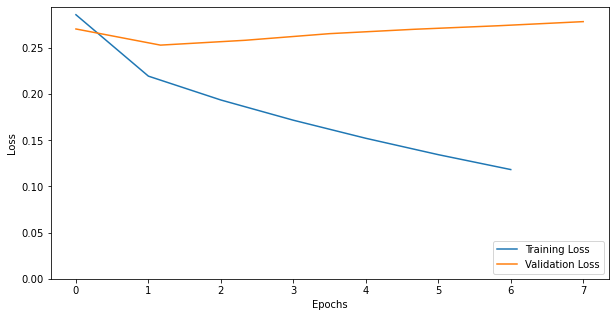

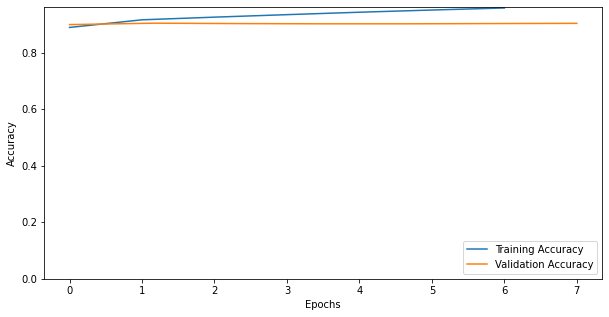

In [209]:
plt.figure(figsize = (20,10))
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['acc'], history.history['val_acc'], x_label='Epochs', stats='accuracy')
plt.show()

##### Xception

In [141]:
baseline_model = build_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_11 (Dense)             (None, 46)                5934      
Total params: 2,427,886
Trainable params: 169,902
Non-trainable params: 2,257,984
_________________________________________________________________


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_7 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 169,902
Non-trainable params: 2,257,984
_________________________________________________________________
None
Train for 75.0 steps, validate for 19.0 steps
Epoch 1/50
74/75 [============================>.] - ETA: 0s - loss: 0.4736 - acc: 0.7932
Epoch 00001: val_acc improved from -inf to 0.87568, saving model to /home/jupyter/iMaterialist/m

<Figure size 1440x720 with 0 Axes>

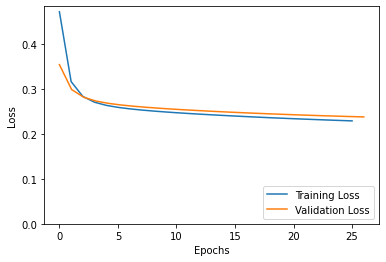

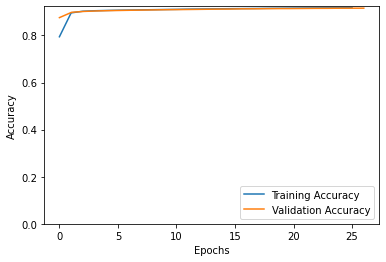

CPU times: user 8min 52s, sys: 1min 44s, total: 10min 36s
Wall time: 9min 5s


In [134]:
%%time
EPOCHS = 50

# Train the baseline model
history = baseline_model.fit(train_ds,
                  steps_per_epoch = num_steps_train,
                  epochs = EPOCHS,
                  validation_data = val_ds,
                  validation_steps = num_steps_val,
                  callbacks=[cp_callback, es_callback])

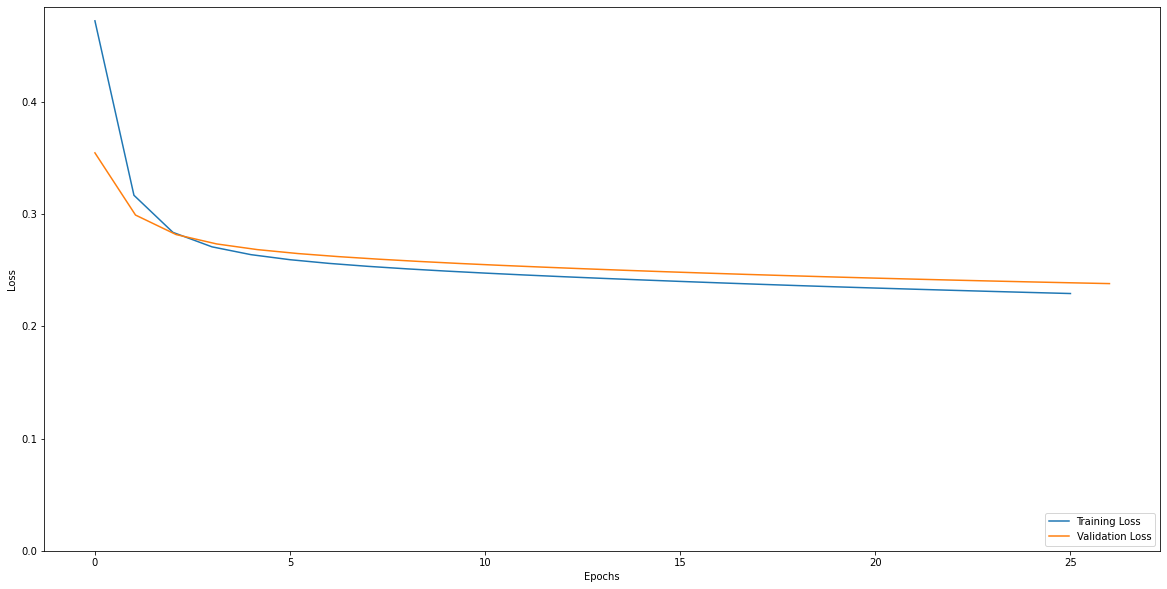

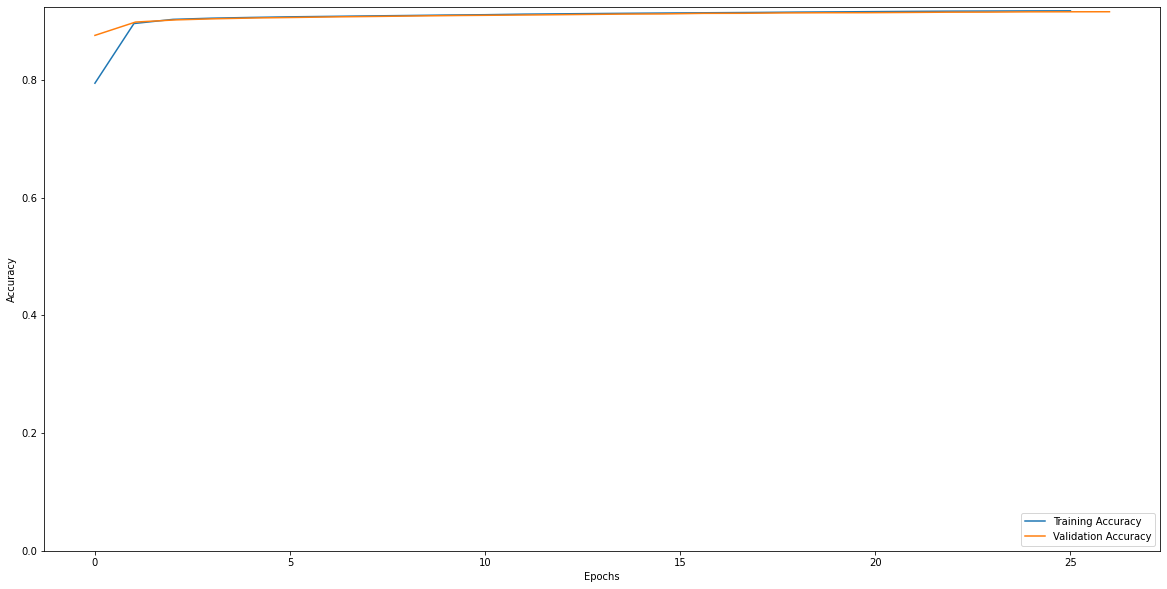

In [139]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['acc'], history.history['val_acc'], x_label='Epochs', stats='accuracy')

##### Conclusion

The result show that 2 model have nearly the same performance. But the MobileNetV2 is lighter, so it will be chosen for my model

#### 2.2.3 Dense layers set selection

I will make a comparison between some different dense layers to choose the best one

In [33]:
dense_layers_list = [[128],[512],[128,128],[128,256],[256,256]]

In [173]:
%%time
for dense_layer in dense_layers_list:
    model = build_model(dense_layers=dense_layer)
    print(model.summary())

    num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
    num_steps_val = tf.math.ceil(float(VAL_SAMPLES)/BATCH_SIZE)
    EPOCHS = 50
    
    filepath = os.path.join(MODEL_FOLDER,str(dense_layer)+'model.h5')
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        monitor='val_acc',
        verbose=1)

    # Train the baseline model
    history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback, es_callback])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_10  (None, 1280)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_21 (Dense)             (None, 46)                5934      
Total params: 2,427,886
Trainable params: 169,902
Non-trainable params: 2,257,984
_________________________________________________________________
None
Train for 75.0 steps, validate for 19.0 steps
Epoch 1/50
73/75 [============================>.] - ETA: 0s - loss: 0.2684 - acc: 0.9002 - ETA: 7s - loss: 0.3238 - acc: 0.870 - ETA: 6s - loss: 0.3148 - acc: 0.8 - ETA: 3s - loss: 0.3

In [35]:
acc_list = []
loss_list = []
num_steps_train = tf.math.ceil(float(TRAIN_SAMPLES)/BATCH_SIZE)              
num_steps_val = tf.math.ceil(float(VAL_SAMPLES)/BATCH_SIZE)
for dense_layer in dense_layers_list:
    filepath = os.path.join(MODEL_FOLDER,str(dense_layer)+'model.h5')
    new_model = tf.keras.models.load_model(filepath)
    train_loss, train_acc = new_model.evaluate(train_ds, steps=num_steps_train,  verbose=2)
    val_loss, val_acc = new_model.evaluate(val_ds, steps=num_steps_val,  verbose=2)
    acc_list.append((train_acc,val_acc))
    loss_list.append((train_loss,val_loss))

75/75 - 142s - loss: 0.2197 - acc: 0.9214
19/19 - 32s - loss: 0.2200 - acc: 0.9206
75/75 - 2s - loss: 0.2180 - acc: 0.9211
19/19 - 14s - loss: 0.2185 - acc: 0.9214
75/75 - 2s - loss: 0.2172 - acc: 0.9213
19/19 - 15s - loss: 0.2166 - acc: 0.9228
75/75 - 2s - loss: 0.2176 - acc: 0.9218
19/19 - 14s - loss: 0.2201 - acc: 0.9206
75/75 - 2s - loss: 0.2232 - acc: 0.9213
19/19 - 14s - loss: 0.2237 - acc: 0.9226


##### Conclustion

As you can see in the below result, defferent dense layers set with defferent degree of complexity give us nearly the same performance model. 

So I will use the basic dense layer with 128 neuron for my model.

In [37]:
for dense_layer, acc, loss in zip(dense_layers_list, acc_list, loss_list):
    print(str(dense_layer), 'train loss: {:5.2f}, train accuracy: {:5.2f}%, val loss: {:5.2f}, val accuracy: {:5.2f}%'.format(loss[0], 100*acc[0],loss[1], 100*acc[1]))

[128] train loss:  0.22, train accuracy: 92.14%, val loss:  0.22, val accuracy: 92.06%
[512] train loss:  0.22, train accuracy: 92.11%, val loss:  0.22, val accuracy: 92.14%
[128, 128] train loss:  0.22, train accuracy: 92.13%, val loss:  0.22, val accuracy: 92.28%
[128, 256] train loss:  0.22, train accuracy: 92.18%, val loss:  0.22, val accuracy: 92.06%
[256, 256] train loss:  0.22, train accuracy: 92.13%, val loss:  0.22, val accuracy: 92.26%


### 2.2.4 F1 score evaluation metric

In [49]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1 score as a cost(average 1 - soft-F1 across all labels).
       Use probability values instead of binary predictions.
       Args: 
           y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
           y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
           
       Returns: 
           cost (scalar Tensor): value of the cose function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    
    tp = tf.reduce_sum(y_hat * y, axis = 0)
    fp = tf.reduce_sum(y_hat * (1-y), axis = 0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis = 0)
    
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    
    cost = 1 - soft_f1 # Reduce 1 - soft_f1 to increase soft_f1
    macro_cost = tf.reduce_mean(cost) #average on all labels
    return macro_cost

In [50]:
@tf.function 
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1 score on a batch of observations (average F1 across labels).
       Args: 
           y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
           y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
           thresh: probability value above which we predict positive
           
       Returns: 
           macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1-y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1-y_pred) * y, axis=0), tf.float32)
    
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    
    return macro_f1

In [50]:
%%time
EPOCHS = 50

LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

model = build_model(loss=[macro_soft_f1],metrics=[macro_f1])

filepath = os.path.join(MODEL_FOLDER,'F1_test_model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)

history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 169,902
Non-trainable params: 2,257,984
_________________________________________________________________
Train for 3638.0 steps, validate for 1560.0 steps
Epoch 1/50
  12/3638 [..............................] - ETA: 2:09:44 - loss: 0.6785 - macro_f1: 0.1436WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

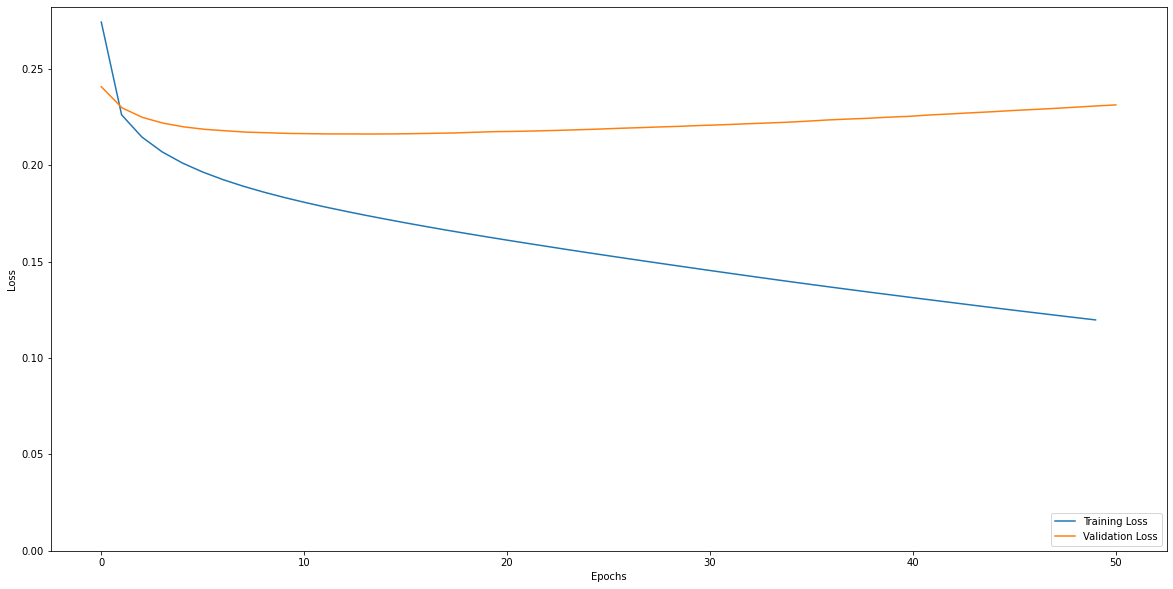

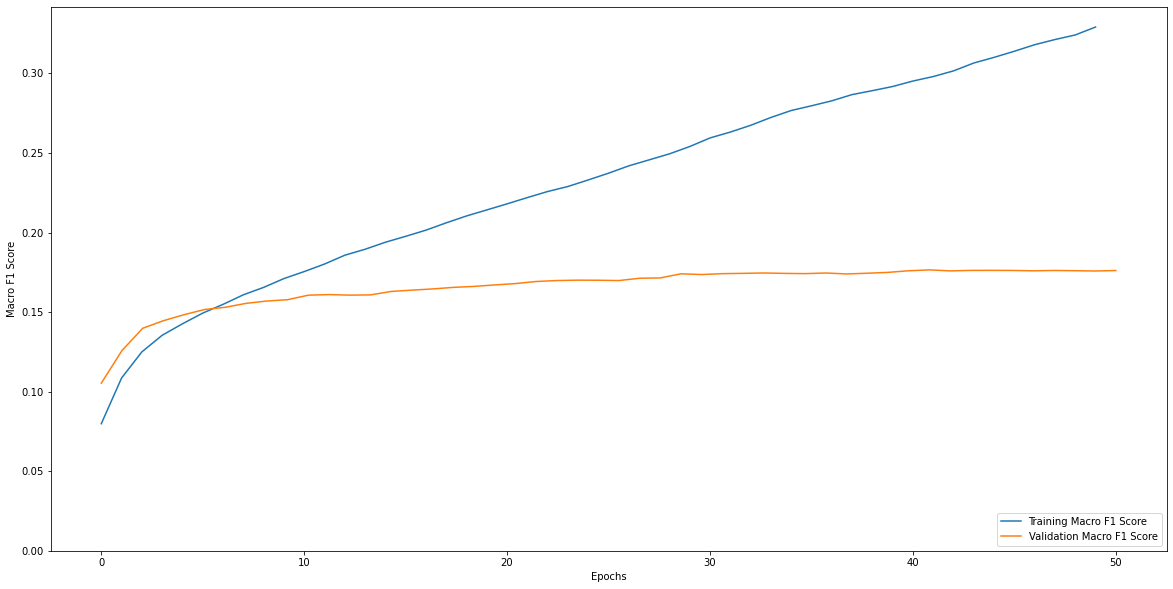

In [163]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['macro_f1'], history.history['val_macro_f1'], x_label='Epochs', stats='macro f1 score');

Try with Drop Out

In [49]:
%%time
EPOCHS = 50
LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

model = build_model(loss=[macro_soft_f1],metrics=[macro_f1], dropout=True, dropout_ratio=0.1)

filepath = os.path.join(MODEL_FOLDER,'F1_test_model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback,es_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 169,902
Non-trainable params: 2,257,984
______________________________________

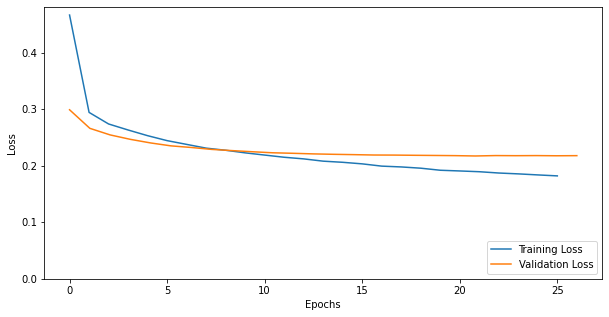

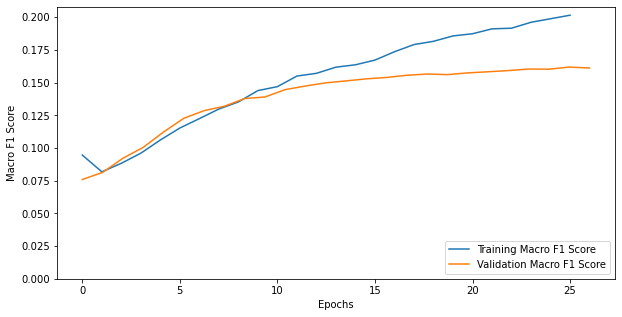

In [50]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['macro_f1'], history.history['val_macro_f1'], x_label='Epochs', stats='macro f1 score');

Add reduce learning rate on plateau

In [188]:
%%time
model = build_model(loss=[macro_soft_f1],metrics=[macro_f1], dropout=True, dropout_ratio=0.1)
EPOCHS = 50

LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

filepath = os.path.join(MODEL_FOLDER,'F1_test_model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        save_weights_only=True
        monitor='val_loss',
        verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback,es_callback, reduce_lr])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_16  (None, 1280)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
___________________________________

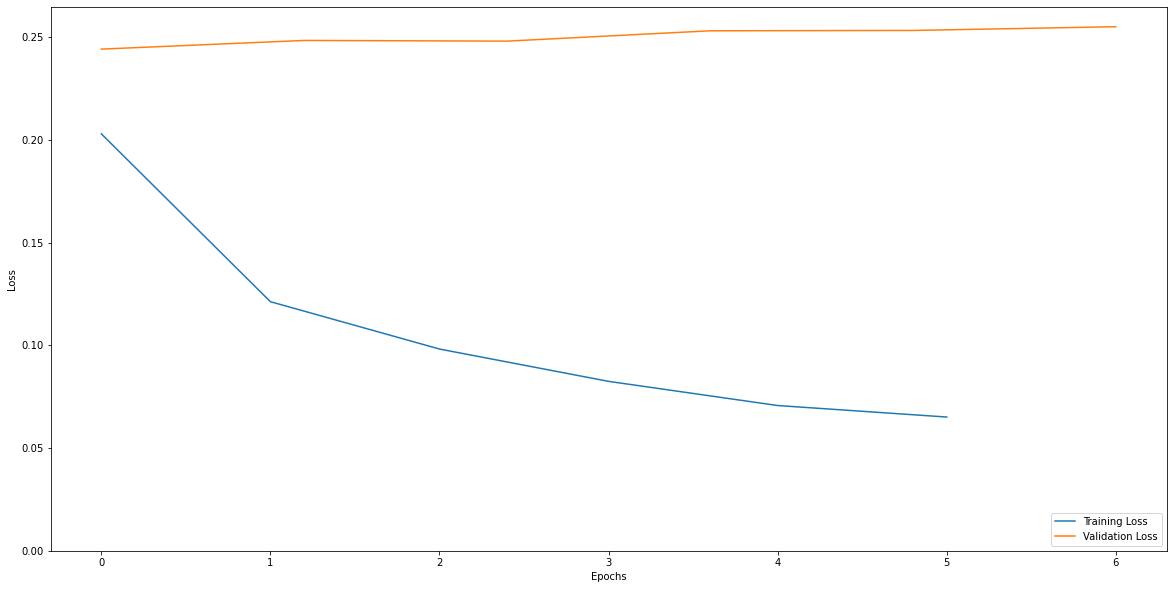

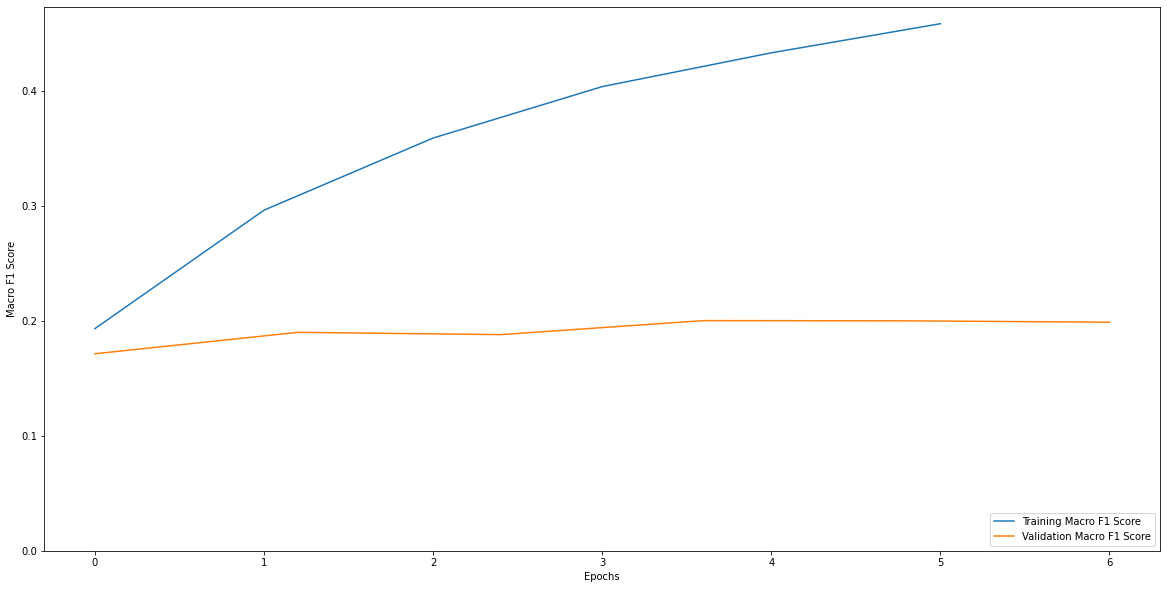

In [189]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['macro_f1'], history.history['val_macro_f1'], x_label='Epochs', stats='macro f1 score');

Unfrezze some layers in MobileNetV2

In [48]:
layers_name = [layer.name for layer in MobileNetV2.layers][-11:]
MobileNetV2.trainable= True
set_trainable = False
for layer in MobileNetV2.layers:
    if layer.name in layers_name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in MobileNetV2.layers]
data = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
data.tail(20)

,Layer Type,Layer Name,Layer Trainable
135,<tensorflow.python.keras.layers.convolutional....,block_15_expand,False
136,<tensorflow.python.keras.layers.normalization....,block_15_expand_BN,False
137,<tensorflow.python.keras.layers.advanced_activ...,block_15_expand_relu,False
138,<tensorflow.python.keras.layers.convolutional....,block_15_depthwise,False
139,<tensorflow.python.keras.layers.normalization....,block_15_depthwise_BN,False
140,<tensorflow.python.keras.layers.advanced_activ...,block_15_depthwise_relu,False
141,<tensorflow.python.keras.layers.convolutional....,block_15_project,False
142,<tensorflow.python.keras.layers.normalization....,block_15_project_BN,False
143,<tensorflow.python.keras.layers.merge.Add obje...,block_15_add,False
144,<tensorflow.python.keras.layers.convolutional....,block_16_expand,True


In [210]:
%%time
EPOCHS = 50

LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

model = build_model(loss=[macro_soft_f1],metrics=[macro_f1], dropout=True, dropout_ratio=0.1)

filepath = os.path.join(MODEL_FOLDER,'F1_test_model.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights = True,
    patience=5,
    verbose=1)

history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback,es_callback])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
____________________________________

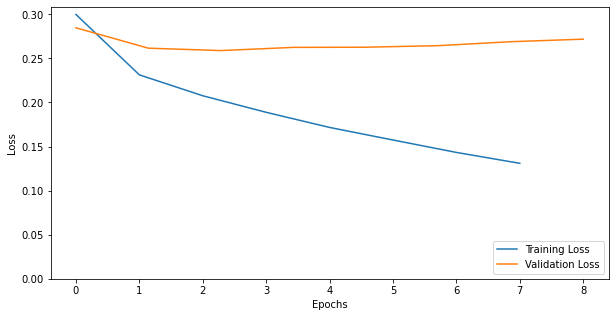

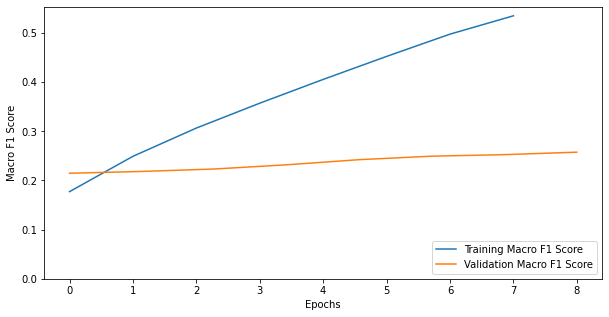

In [224]:
plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['macro_f1'], history.history['val_macro_f1'], x_label='Epochs', stats='macro f1 score');

#### 2.2.5 Comparison between Accuraccy Metric and F1 Score Metric

* Confution matrix

Load the Accuracy Metric Model

In [232]:
filepath = os.path.join(MODEL_FOLDER,'MobileNetV2_model.h5')
accuracy_model = build_model()
accuracy_model.load_weights(filepath)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_11 (Dense)             (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
_________________________________________________________________


Load the F1 Score Metric model

In [227]:
filepath = os.path.join(MODEL_FOLDER,'F1_test_model.h5')
f1_score_model = build_model(loss=[macro_soft_f1],metrics=[macro_f1], dropout=True, dropout_ratio=0.1)
f1_score_model.load_weights(filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
____________________________________

Create the confusion matrix

In [161]:
X_val_img = tf.data.Dataset.from_tensor_slices(X_val)

In [331]:
y_prediction_acc = accuracy_model.predict(val_ds, steps = num_steps_val)
y_prediction_f1 = f1_score_model.predict(val_ds, steps = num_steps_val)

In [334]:
y_prediction_acc.shape ,y_prediction_f1.shape

((64, 46), (64, 46))

In [335]:
cf_acc = multilabel_confusion_matrix(y_val[:50], y_prediction_acc[:50]>0.5)
cf_f1 = multilabel_confusion_matrix(y_val[:50], y_prediction_f1[:50]>0.5)

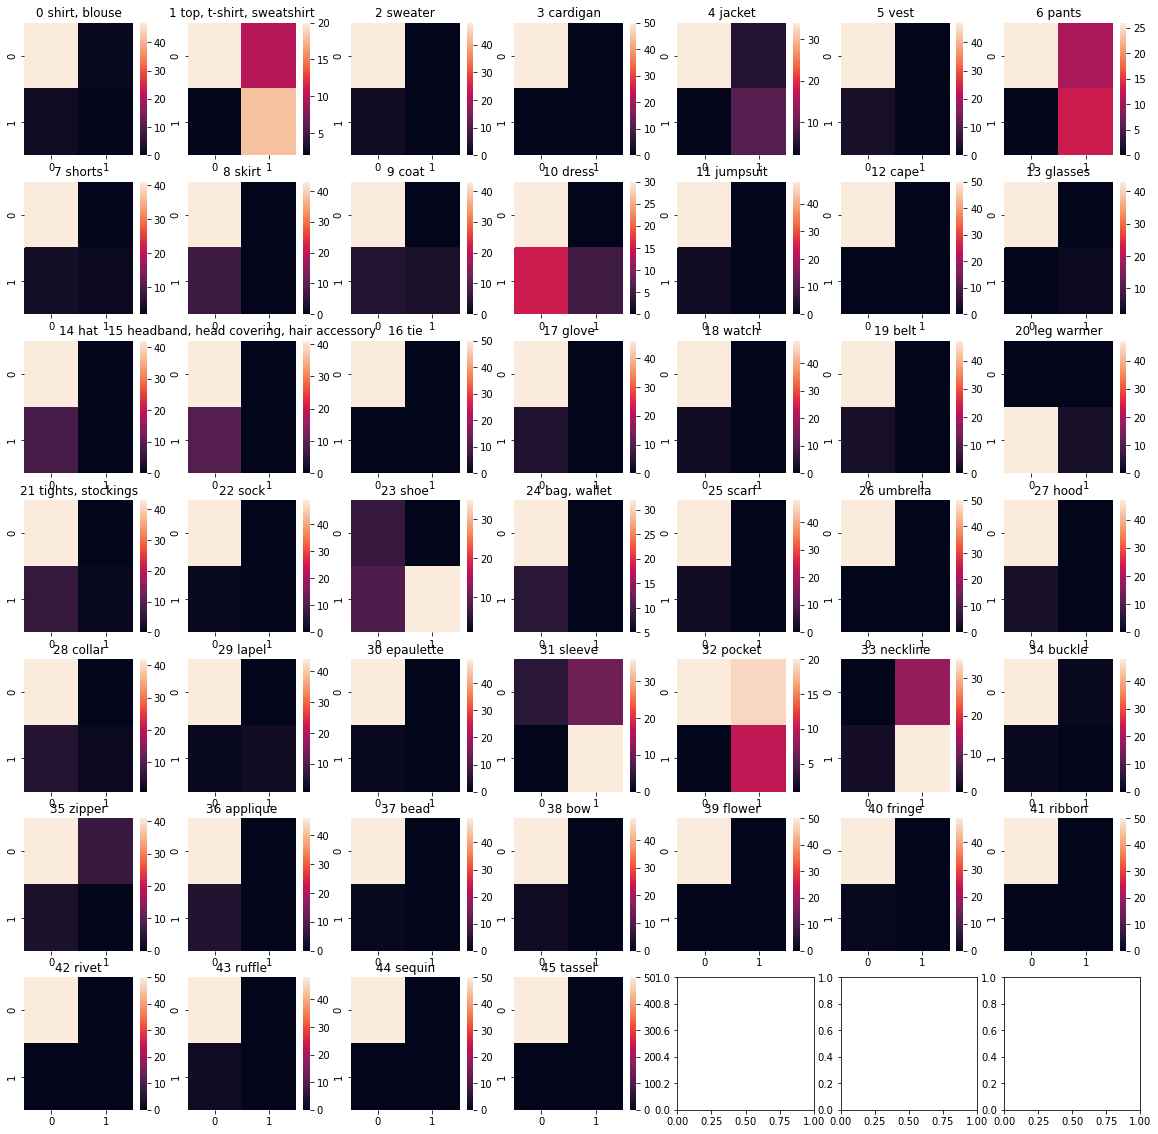

In [336]:
fig, ax = plt.subplots(7,7, figsize=(20,20))
for index, x in enumerate(cf_acc):
    sns.heatmap(x, ax = ax[index//7,index%7])
    ax[index//7,index%7].set_title(str(index)+" "+label_description[index])

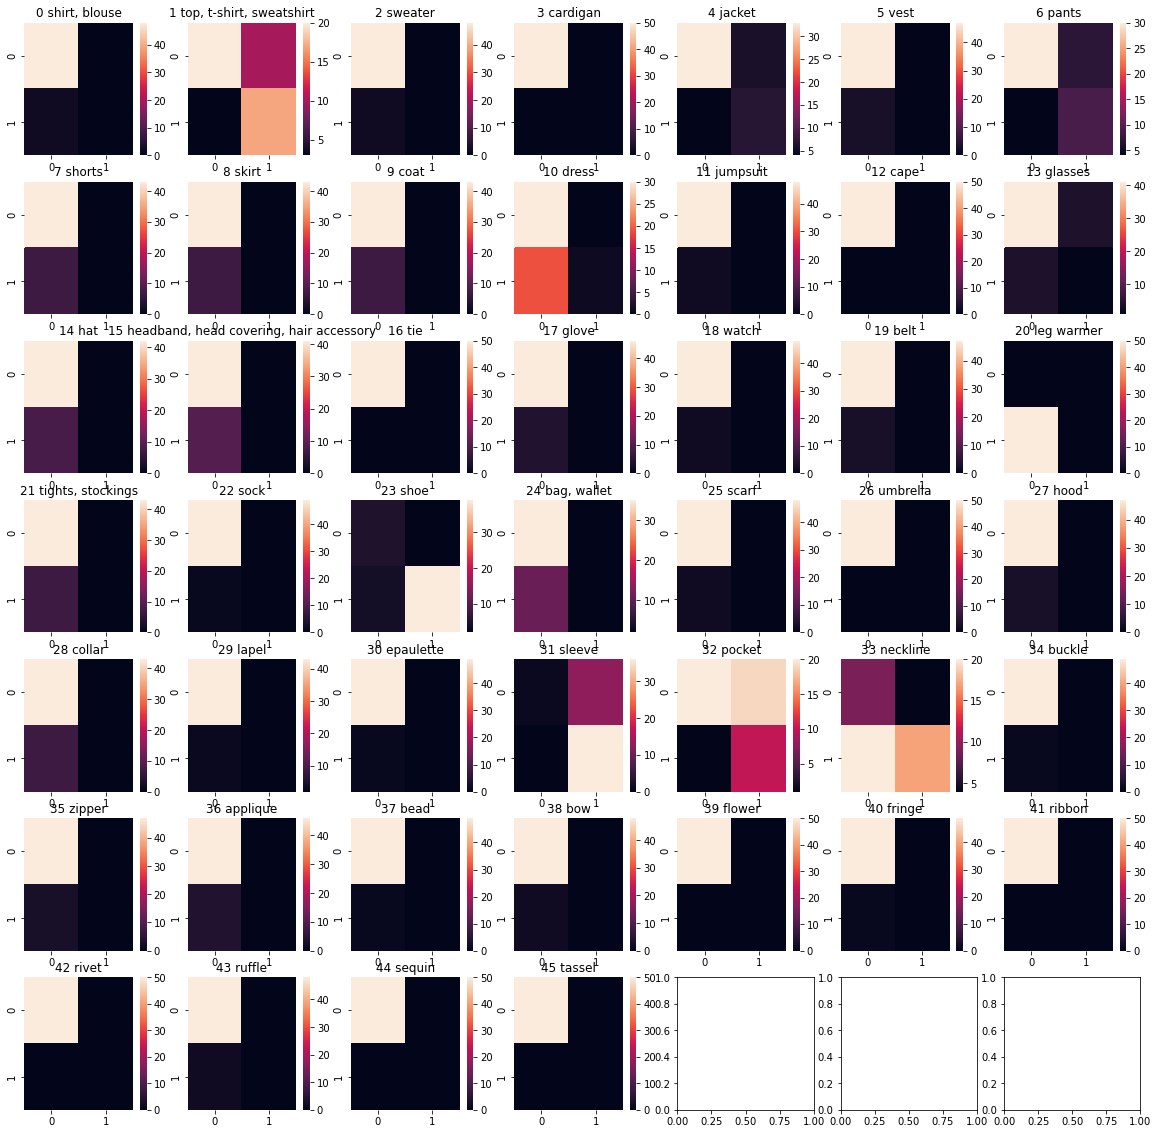

In [337]:
fig, ax = plt.subplots(7,7, figsize=(20,20))
for index, x in enumerate(cf_f1):
    sns.heatmap(x, ax = ax[index//7,index%7])
    ax[index//7,index%7].set_title(str(index)+" "+label_description[index])

* Conclusion: There is no significant dirrent between 2 method

* Example

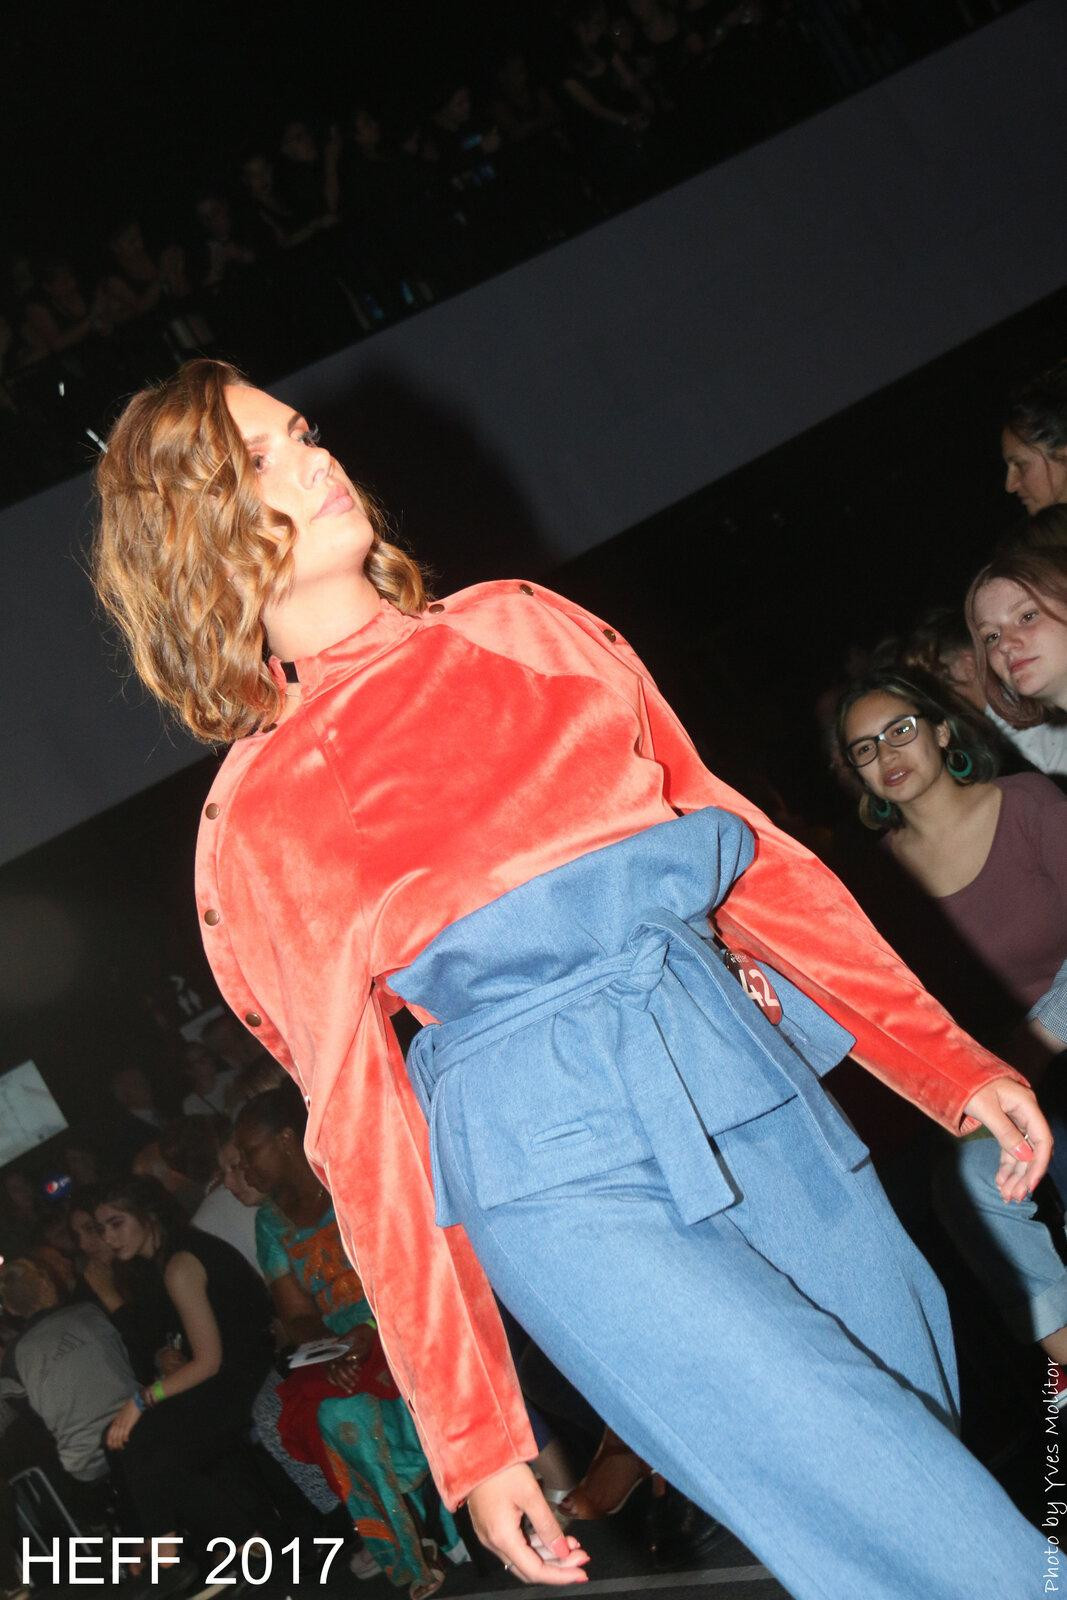

In [102]:
def preprocess(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = (image*2) - 1  # normalize to [-1,1] range
    image = tf.image.per_image_standardization(image)
    return image

name = '000775b6b5e27b011dc8bba2d7b85211'
path = os.path.join(DATA_TRAIN_FOLDER,name+'.jpg')
image = np.expand_dims(preprocess(path), axis = 0)
display.display(display.Image(filename=path,width = 224, height = 224))

In [131]:
accuracy_prediction =  np.argwhere(accuracy_model.predict(image)>0.5)[:,1]
set(map(lambda x: label_description[x], accuracy_prediction))

{'collar', 'lapel', 'neckline', 'pants', 'pocket', 'shoe', 'sleeve'}

In [132]:
f1_score_prediction =  np.argwhere(f1_score_model.predict(image)>0.5)[:,1]
set(map(lambda x: label_description[x], f1_score_prediction))

{'collar', 'jacket', 'neckline', 'pants', 'pocket', 'shirt, blouse', 'sleeve'}

In [133]:
label = data[data['ImageId']==name]['ClassId'].to_numpy()
set(map(lambda x: label_description[x], label))

{'belt', 'neckline', 'pants', 'sleeve', 'top, t-shirt, sweatshirt'}

### 2.3 Training

In [ ]:
%%time
EPOCHS = 50

LR = 1e-4
nadam = tf.keras.optimizers.Nadam(learning_rate = LR)

model = build_model(loss=[macro_soft_f1],metrics=[macro_f1], dropout=True, dropout_ratio=0.1)

filepath = os.path.join(MODEL_FOLDER,'F1_model_2.h5')
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_loss',
        verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

history = model.fit(train_ds,
                      steps_per_epoch = num_steps_train,
                      epochs = EPOCHS,
                      validation_data = val_ds,
                      validation_steps = num_steps_val,
                      callbacks=[cp_callback,es_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 2,427,886
Trainable params: 1,055,982
Non-trainable params: 1,371,904
______________________________________

In [ ]:
model.save(filepath)

## 3. SUMMARRY

* Task: Multilabel Classification (46 classes) with Unbalanced dataset

* Solutions:
    * Random Oversampling for Unbalanced dataset 
    * F1 Score metric for Multilabel Classfication

* Problem: 
    * Unsolved problem when train the whole dataset  - 160k images "Resource exhausted"
    * Model hardly recognize minority class

* Proposed for next step
    * Try order solution for Unbalanced dataset (imbalanced learn library)